# Model Selection and Tuning

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, classification_report, plot_roc_curve, roc_auc_score, 
accuracy_score, precision_score, recall_score, f1_score, auc, precision_recall_curve, average_precision_score)

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier

from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE

pd.set_option('display.max_rows', 500)

In [ ]:
# Import datasets
train = pd.read_csv('./datasets/train.csv')
test = pd.read_csv('./datasets/test.csv')
weather = pd.read_csv('./datasets/cleaned_weather.csv')
final_train = pd.read_csv('./datasets/final_train.csv')
final_test = pd.read_csv('./datasets/final_test.csv')

In [ ]:
test_id = test['Id']

In this section, we tested out a variety of predictive models including a Logistic Regression classifier and tree-based algorithms like AdaBoost. We carried out the following process:
- Train-test-split data
- Calculate baseline and benchmark models
- Fit model to training date
- Ran models on our data without using any over- or under-sampling techniques to benchmark performance
- Used the <b>Synthetic Minority Oversampling Technique (SMOTE)</b> to address the class imbalance within our target variable
- Carried out hyper-parameter tuning on our most promising models 
- Identified our top performing model based on ROC-AUC score


### Train Test Split

Ultimately, we opted to drop these features. Dropping year led to no change in performance (we have YearWeek instead), and our other three polynomial features
didn't give us a high enough increase in model AUC to justify the decreased interpretability of our model.

In [ ]:
final_train = final_train.drop(columns=['Year', 'Sunrise_WeekAvgTemp', 'Sunrise_WetBulb', 'Week_WeekAvgTemp'])
final_test = final_test.drop(columns=['Year', 'Sunrise_WeekAvgTemp', 'Sunrise_WetBulb', 'Week_WeekAvgTemp'])

In [ ]:
X = final_train
y = train['WnvPresent']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

### Baseline Model

Looking at the class imbalance within our target variable 
immediately highlights the issue of using accuracy or R<sup>2</sup> 
as a metric for our model. The dataset we're using is strongly biased towards 
samples where WNV is absent. This means that simply classifing every data point as absent of WNV would <b>net our model an accuracy of almost 95%</b>. 

In this situation, we need a different metric that will help us avoid overfitting to a single class. Using Area Under Curve (AUC) is a great alternative, as it focuses on our sensitivity and specificity of our model. To elaborate, AUC measures how true positive rate (recall) and false positive rate trade off. This reveals how good a model is at distinguishing between positive class and negative class.

Using a AUC Reciever Operating Characteristic or AUC-ROC curve, <b>we can visually compare the true positive and false positive rates at a range of different classification thresholds to identify our best model</b>.

In [ ]:
# Baseline
y = train['WnvPresent']
y.value_counts(normalize=True)

0    0.947554
1    0.052446
Name: WnvPresent, dtype: float64

### Model Preparation

In [ ]:
# Instiantiate models
models = {'lr': LogisticRegression(max_iter=5_000, random_state=42, solver='saga'),
          'rf': RandomForestClassifier(random_state=42),
          'gb': GradientBoostingClassifier(random_state=42),
          'dt': DecisionTreeClassifier(random_state=42),
          'et': ExtraTreesClassifier(random_state=42),
          'ada': AdaBoostClassifier(random_state=42),
          'svc': SVC(random_state=42, probability=True),
        }

In [ ]:
# Instantiate lists to store results
init_list = []
gs_list = []

# Function to run model -- input scaler and model
def run_model(mod, mod_params={}, grid_search=False):
    
    # Initial dictionary to hold model results
    results = {}
    
    pipe = Pipeline([
            ('ss', StandardScaler()),
            (mod, models[mod])
            ])
    
    if grid_search:
        # Instantiate list to store gridsearch results
        gs = GridSearchCV(pipe, param_grid=mod_params, cv=3, verbose=1, scoring='roc_auc', n_jobs=-1)
        gs.fit(X_train, y_train)
        pipe = gs
        
    else:
        pipe.fit(X_train, y_train)
    
    # Retrieve metrics
    predictions = pipe.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    y_test_pred_prob = pipe.predict_proba(X_test)[:,1]
    y_train_pred_prob = pipe.predict_proba(X_train)[:,1]
    
    results['model'] = mod
    results['train_auc'] = roc_auc_score(y_train, y_train_pred_prob)
    results['test_auc'] = roc_auc_score(y_test, y_test_pred_prob)
    results['precision'] = precision_score(y_test, predictions)
    results['specificity'] = tn / (tn + fp)
    results['recall'] = recall_score(y_test, predictions)
    results['f_score'] = f1_score(y_test, predictions)
    
    if grid_search:
        gs_list.append(results)
        print('### BEST PARAMS ###')
        display(pipe.best_params_)
        
    else:
        init_list.append(results)
    
    print('### METRICS ###')
    display(results)
    
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}")
    
    return pipe

## Model Benchmarks 
Here, we're simply running our models with no class adjustments and no hyper-parameter tuning. It's worth noting that <b>without feature engineering, our models performed substantially worse.</b> In iterations without feature engineering our Logistic Regression and AdaBoosting classifiers completely failed to identify any true positives.

In [ ]:
lr = run_model('lr')

### METRICS ###


{'model': 'lr',
 'train_auc': 0.852268400920864,
 'test_auc': 0.8315934706962494,
 'precision': 0.6363636363636364,
 'specificity': 0.9986608637428859,
 'recall': 0.04242424242424243,
 'f_score': 0.07954545454545454}

True Negatives: 2983
False Positives: 4
False Negatives: 158
True Positives: 7


In [ ]:
dt = run_model('dt')

### METRICS ###


{'model': 'dt',
 'train_auc': 0.9886237901762609,
 'test_auc': 0.6690903003926105,
 'precision': 0.26,
 'specificity': 0.962838968865082,
 'recall': 0.23636363636363636,
 'f_score': 0.24761904761904763}

True Negatives: 2876
False Positives: 111
False Negatives: 126
True Positives: 39


In [ ]:
rf = run_model('rf')

### METRICS ###


{'model': 'rf',
 'train_auc': 0.9864071432395616,
 'test_auc': 0.7614207018291385,
 'precision': 0.3090909090909091,
 'specificity': 0.9745564111148309,
 'recall': 0.20606060606060606,
 'f_score': 0.24727272727272728}

True Negatives: 2911
False Positives: 76
False Negatives: 131
True Positives: 34


In [ ]:
gb = run_model('gb')

### METRICS ###


{'model': 'gb',
 'train_auc': 0.9061453394644949,
 'test_auc': 0.840763510565988,
 'precision': 0.3684210526315789,
 'specificity': 0.9959825912286575,
 'recall': 0.04242424242424243,
 'f_score': 0.07608695652173914}

True Negatives: 2975
False Positives: 12
False Negatives: 158
True Positives: 7


In [ ]:
et = run_model('et')

### METRICS ###


{'model': 'et',
 'train_auc': 0.9886237901762609,
 'test_auc': 0.7041807428148238,
 'precision': 0.28448275862068967,
 'specificity': 0.9722129226648811,
 'recall': 0.2,
 'f_score': 0.23487544483985764}

True Negatives: 2904
False Positives: 83
False Negatives: 132
True Positives: 33


In [ ]:
svc = run_model('svc')

### METRICS ###


C:\Users\benja\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'model': 'svc',
 'train_auc': 0.8549137284878914,
 'test_auc': 0.7638260746061214,
 'precision': 0.0,
 'specificity': 1.0,
 'recall': 0.0,
 'f_score': 0.0}

True Negatives: 2987
False Positives: 0
False Negatives: 165
True Positives: 0


In [ ]:
ada = run_model('ada')

### METRICS ###


{'model': 'ada',
 'train_auc': 0.8671748124661666,
 'test_auc': 0.830862018240659,
 'precision': 0.6666666666666666,
 'specificity': 0.9989956478071644,
 'recall': 0.03636363636363636,
 'f_score': 0.06896551724137931}

True Negatives: 2984
False Positives: 3
False Negatives: 159
True Positives: 6


At this point, it's a bit hard to conclude which is the best classification model. Our Gradient Boosting classfier has the best test AUC scores, but it scores poorly in terms of sensitivity, suggesting that the model isn't good at identifying true positives (i.e. mosquito pools where WNV is present).

Conversely, some of our non-boosting tree classifiers have higher f-scores and are better at predicting true positives, but score poorly in terms of test AUC. This means that our positive and negative populations are overlapping to some degree. This means our model isn't good at predicting WNV - this is also reflected by the high number of positive and negative misclassifications (e.g. our decision tree classifier has the highest number of misclassifications - 246 false positives and 116 false negatives).

In [ ]:
# Results of our initial modelling
pd.DataFrame(init_list).sort_values(by='test_auc', ascending=False).reset_index(drop=True)

,model,train_auc,test_auc,precision,specificity,recall,f_score
0,gb,0.906145,0.840764,0.368421,0.995983,0.042424,0.076087
1,lr,0.852268,0.831593,0.636364,0.998661,0.042424,0.079545
2,ada,0.867175,0.830862,0.666667,0.998996,0.036364,0.068966
3,svc,0.854914,0.763826,0.000000,1.000000,0.000000,0.000000
4,rf,0.986407,0.761421,0.309091,0.974556,0.206061,0.247273
5,et,0.988624,0.704181,0.284483,0.972213,0.200000,0.234875
6,dt,0.988624,0.669090,0.260000,0.962839,0.236364,0.247619


### AUC-ROC Evaluation

In [ ]:
init_dict = {
    lr: 'LogisticRegression',
    gb: 'GradientBoostingClassifier',
    ada: 'AdaBoostClassifier',
    rf: 'RandomForest',
    svc: 'SupportVectorMachineCl',
    et: 'ExtraTrees',
    dt: 'DecisionTreeClassifier',
}

In [ ]:
def roc_curve_plotter(model_dict, plot_top=False):
    fig, ax = plt.subplots(1, 1, figsize=(12,10))
    axes = {}
    for i, m in enumerate(model_dict.keys()):
        axes[f'ax{i}'] = plot_roc_curve(m, X_test, y_test, ax=ax, name=model_dict[m])
    if plot_top:
        for i, a in enumerate(axes):
            if i != 0:
                axes[a].line_.set_color('lightgrey')
    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Random Guess')
    plt.title('ROC-AUC Curve Comparison', fontsize=22)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.legend(fontsize=12)

We can confirm our initial analysis by looking at an AUC-ROC curve comparing all of our models. Our non-boosting tree classifiers tend to have a sharp drop off in true positive versus false positive rate after a specific threshold. In comparison, our Logistic Regression and Boosting models seem to be performing better in terms of AUC. 

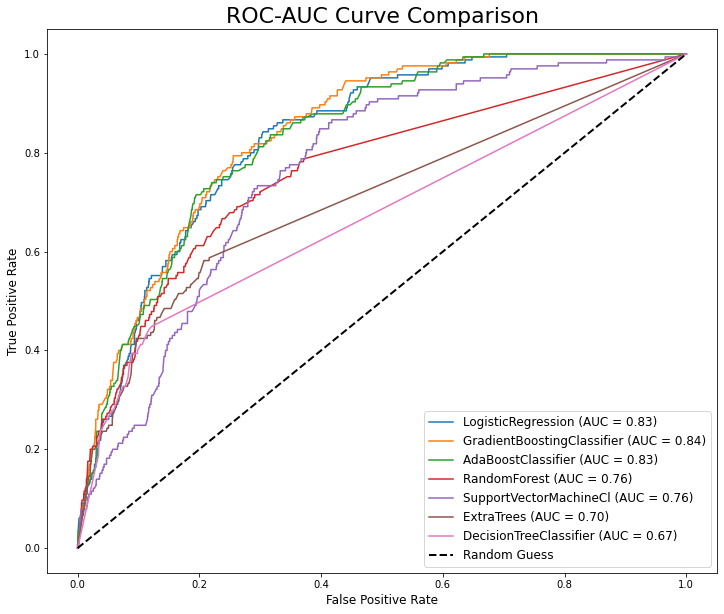

In [ ]:
roc_curve_plotter(init_dict)

A reason for this could be that <b>our two classes aren't separated by a non-linear boundary</b>. As Decision Trees work by bisecting data into smaller and smaller regions, they tend to work pretty well in situations where there's a non linear boundary separating our data. Given that our classes don't seem to have any obvious 
pattern of non-linear separation throughout any of our features, 
our tree models are likely to overfit heavily. 
The simple linear boundary that Logistic Regression is most likely better in capturing the division between our classes.

To give an example of this, you can take a look at the below two graphs that demonstrate how a Decision Tree classifier could overfit when there's no clear separation between classes.
We can see that Logistic Regression is a better tool for this particular job.
<img src="/assets/boundaries.png" alt="Decision Tree Non-Linear Boundary"
	title="Decision Tree Overfitting due to Non-Linear Boundary" width="800" height="300" />

Source: [BigML](https://blog.bigml.com/2016/09/28/logistic-regression-versus-decision-trees/)


As for our boosting algorithms, it seems likely that they're  performing well due to their ability to deal with imbalanced classes by constructing successive training sets based on incorrectly classified examples. 

In the next section, we'll try out hyperparameter tuning with all our models along with an oversampling techinque to address our class imbalance.

## Hyperparameter Tuning with SMOTE

SMOTE is a commonly used oversampling method that attempts to balance class distribution by randomly increasing minority class examples by replicating them. In short, SMOTE synthesises new minority instances between existing minority instances. SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line. 

SMOTE is a pretty good choice here, given our imbalanced classes. Another option that we considered was <b>class weights</b>, where a heavier weightage is placed on the minority class and vice-versa for the majority class. However, we opted for SMOTE as some models like our Gradient Boosting classifier can't use class weights.

In [ ]:
smt = SMOTE()
X_train, y_train = smt.fit_sample(X_train, y_train)

### Logistic Regression

In [ ]:
lr_params = {
    # Trying different types of regularization
    'lr__penalty':['l2','l1', 'elasticnet'],

     # Trying different alphas of: 1, 0.1, 0.05  (C = 1/alpha)
    'lr__C':[1, 10, 20],
}

In [ ]:
lr_gs = run_model('lr', mod_params=lr_params, grid_search=True)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   22.4s finished


### BEST PARAMS ###


{'lr__C': 20, 'lr__penalty': 'l1'}

### METRICS ###


{'model': 'lr',
 'train_auc': 0.8585618374666015,
 'test_auc': 0.8240151768775806,
 'precision': 0.1367816091954023,
 'specificity': 0.7485771677268162,
 'recall': 0.7212121212121212,
 'f_score': 0.22995169082125605}

True Negatives: 2236
False Positives: 751
False Negatives: 46
True Positives: 119


In [ ]:
# Saving for further analysis
'''train_lr_gs = lr_gs
train_preds = lr_gs.predict(X_test)
train_probs = lr_gs.predict_proba(X_test)
misclass_array = pd.DataFrame({'Actual': y_test, 'Predicted': train_preds}).to_numpy()
misclass_probs = train_probs

filename = './assets/train_gs_model.sav'
pickle.dump(train_lr_gs, open(filename, 'wb'))

filename = './assets/misclass_array.sav'
pickle.dump(misclass_array, open(filename, 'wb'))

filename = './assets/misclass_probs.sav'
pickle.dump(misclass_probs, open(filename, 'wb'))''';

### Decision Tree

In [ ]:
dt_params = {'dt__max_depth': [20, 30, 40, 50],
             'dt__min_samples_split': [1, 5, 10, 15],
             'dt__min_samples_leaf': [2, 3, 4, 5],
             'dt__class_weight': ['balanced']}

In [ ]:
dt_gs =  run_model('dt', mod_params=dt_params, grid_search=True)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:    1.8s finished


### BEST PARAMS ###


{'dt__class_weight': 'balanced',
 'dt__max_depth': 40,
 'dt__min_samples_leaf': 3,
 'dt__min_samples_split': 15}

### METRICS ###


{'model': 'dt',
 'train_auc': 0.9903483766531205,
 'test_auc': 0.7412230777814977,
 'precision': 0.16285714285714287,
 'specificity': 0.9019082691663877,
 'recall': 0.34545454545454546,
 'f_score': 0.2213592233009709}

True Negatives: 2694
False Positives: 293
False Negatives: 108
True Positives: 57


### Extra Trees 

In [ ]:
et_params = {'et__n_estimators': [20, 25, 30, 35],
             'et__max_depth': [20, 30, 40, 50],
             'et__min_samples_leaf': [2, 3, 4],
            }

In [ ]:
et_gs =  run_model('et', mod_params=et_params, grid_search=True)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:    3.9s finished


### BEST PARAMS ###


{'et__max_depth': 40, 'et__min_samples_leaf': 2, 'et__n_estimators': 35}

### METRICS ###


{'model': 'et',
 'train_auc': 0.9758875677856852,
 'test_auc': 0.8102027979831796,
 'precision': 0.15187713310580206,
 'specificity': 0.8336123200535654,
 'recall': 0.5393939393939394,
 'f_score': 0.23701731025299602}

True Negatives: 2490
False Positives: 497
False Negatives: 76
True Positives: 89


### SVC

In [ ]:
svc_params = {
    'svc__C':[10, 30],
    'svc__gamma':[0.01, 0.1], 
    'svc__kernel':['rbf', 'sigmoid'],
}

In [ ]:
svc_gs =  run_model('svc', mod_params=svc_params, grid_search=True)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   46.1s finished


### BEST PARAMS ###


{'svc__C': 30, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}

### METRICS ###


{'model': 'svc',
 'train_auc': 0.9409148130505733,
 'test_auc': 0.7867232756084448,
 'precision': 0.146875,
 'specificity': 0.8172079009039169,
 'recall': 0.5696969696969697,
 'f_score': 0.23354037267080746}

True Negatives: 2441
False Positives: 546
False Negatives: 71
True Positives: 94


### Random Forest

In [ ]:
rf_params = {'rf__n_estimators': [20, 25, 30, 35],
             'rf__max_depth': [20, 30, 40, 50],
             'rf__min_samples_leaf': [2, 3, 4],
            }

In [ ]:
rf_gs =  run_model('rf', mod_params=rf_params, grid_search=True)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:    5.3s finished


### BEST PARAMS ###


{'rf__max_depth': 30, 'rf__min_samples_leaf': 2, 'rf__n_estimators': 30}

### METRICS ###


{'model': 'rf',
 'train_auc': 0.99183172401373,
 'test_auc': 0.8042527721135019,
 'precision': 0.1806615776081425,
 'specificity': 0.89219953130231,
 'recall': 0.4303030303030303,
 'f_score': 0.25448028673835127}

True Negatives: 2665
False Positives: 322
False Negatives: 94
True Positives: 71


### Adaptive Boosting

In [ ]:
ada_params = {'ada__n_estimators': [500, 1000],
              'ada__learning_rate': [0.9, 1.0],
             }

In [ ]:
ada_gs = run_model('ada', mod_params=ada_params, grid_search=True)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  12 | elapsed:    7.9s remaining:   40.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   16.0s finished


### BEST PARAMS ###


{'ada__learning_rate': 1.0, 'ada__n_estimators': 1000}

### METRICS ###


{'model': 'ada',
 'train_auc': 0.9617390360691026,
 'test_auc': 0.8108256992421706,
 'precision': 0.1546572934973638,
 'specificity': 0.8389688650820221,
 'recall': 0.5333333333333333,
 'f_score': 0.23978201634877383}

True Negatives: 2506
False Positives: 481
False Negatives: 77
True Positives: 88


### Gradient Boosting

In [ ]:
gb_params = {'gb__n_estimators': [500, 1000],
             'gb__learning_rate': [0.4, 0.5, 0.6],
}

In [ ]:
gb_gs = run_model('gb', mod_params=gb_params, grid_search=True)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  18 | elapsed:   30.4s remaining:    8.6s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   36.5s finished


### BEST PARAMS ###


{'gb__learning_rate': 0.4, 'gb__n_estimators': 1000}

### METRICS ###


{'model': 'gb',
 'train_auc': 0.9979887452530247,
 'test_auc': 0.7991691268222906,
 'precision': 0.23809523809523808,
 'specificity': 0.9517910947438902,
 'recall': 0.2727272727272727,
 'f_score': 0.2542372881355932}

True Negatives: 2843
False Positives: 144
False Negatives: 120
True Positives: 45


In [ ]:
gs_df = pd.DataFrame(gs_list)
gs_df.sort_values(by='test_auc', ascending=False)

,model,train_auc,test_auc,precision,specificity,recall,f_score
0,lr,0.858562,0.824015,0.136782,0.748577,0.721212,0.229952
5,ada,0.961739,0.810826,0.154657,0.838969,0.533333,0.239782
2,et,0.975888,0.810203,0.151877,0.833612,0.539394,0.237017
4,rf,0.991832,0.804253,0.180662,0.892200,0.430303,0.254480
6,gb,0.997989,0.799169,0.238095,0.951791,0.272727,0.254237
3,svc,0.940915,0.786723,0.146875,0.817208,0.569697,0.233540
1,dt,0.990348,0.741223,0.162857,0.901908,0.345455,0.221359


### Final AUC-ROC Evaluation

In [ ]:
gs_dict = {
    lr_gs: 'LogisticRegression',
    gb_gs: 'GradientBoostingClassifier',
    ada_gs: 'AdaBoostClassifier',
    rf_gs: 'RandomForest',
    svc_gs: 'SupportVectorMachineClf',
    et_gs: 'ExtraTreeClassifier',
    dt_gs: 'DecisionTreeClassifier',
}

Our Logistic Regression model seems to be a clear winner here in terms of AUC score. Looking at the curve, we can also see that it outperforms other models at most classification thresholds. SMOTE also seems to have helped most of our models improve their AUC score, though it seems that our Support Vector Machine classifier and Decision Tree Classifier are still doing pretty badly.

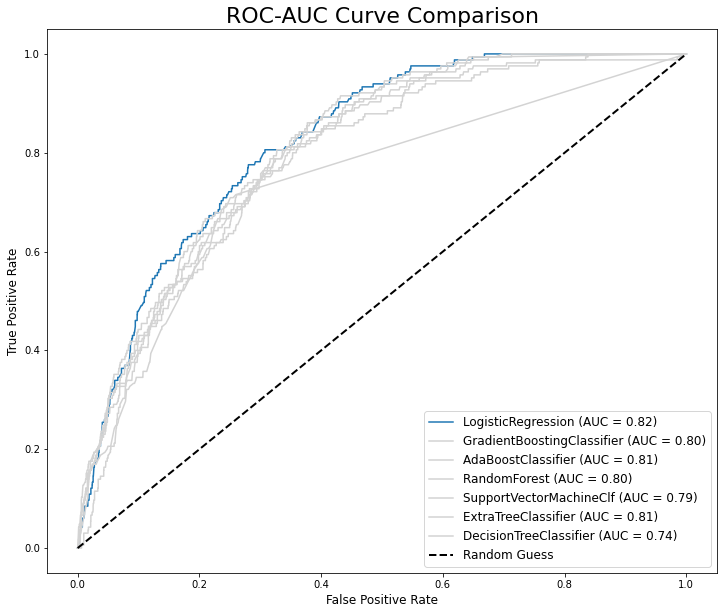

In [ ]:
roc_curve_plotter(gs_dict, plot_top=True)

#### Precision-Recall AUC

Beyond focusing just on AUC which looks how good our modelling is at separating our positive and negative class, we also want to pay close attention to our model's ability to classify most or all of our minority class (which in this case is our positive class). Using a Precision-Recall AUC curve, we can look at the trade-off between precision (number out of true positives out of all predicted positives) and recall (number of true positives out of all predicted results).

In [ ]:
def plot_pr_curve(model, model_dict):
    # Predict probabilities
    probs = model.predict_proba(X_test)
    # Keep probabilities for the positive outcome only
    probs = probs[:, 1]
    # Predict class values
    yhat = model.predict(X_test)
    # Calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, probs)
    # Calculate F1 score
    f1 = f1_score(y_test, yhat)
    # Calculate precision-recall AUC
    auc_score = auc(recall, precision)
    # Calculate average precision score
    ap = average_precision_score(y_test, probs)
    print(f'{model_dict[model]}: f1=%.3f pr-auc=%.3f avg. prec=%.3f' % (f1, auc_score, ap))
    # Plot the ROC curve for the model
    plt.plot(recall, precision, marker='.', label=model_dict[model])
    plt.xlabel('Recall')
    plt.ylabel('Precision')

We can see that at most thresholds, our logistic regression model is able to outperform the other two models in terms of recall. This means that our logistic regression model is doing comparatively well in classifying our positive class. Given that we believe recall to be more important than precision here (ignoring WNV could lead to human death), our logistic regession model seems like a solid choice. If precision was more important for us, we could opt for a gradient boosting classifier instead as it seems to be better at maximising precision over recall at earlier parts of the curve. 

LogisticRegression: f1=0.230 pr-auc=0.182 avg. prec=0.188
DecisionTreeClassifier: f1=0.221 pr-auc=0.195 avg. prec=0.145
GradientBoostingClassifier: f1=0.254 pr-auc=0.177 avg. prec=0.181


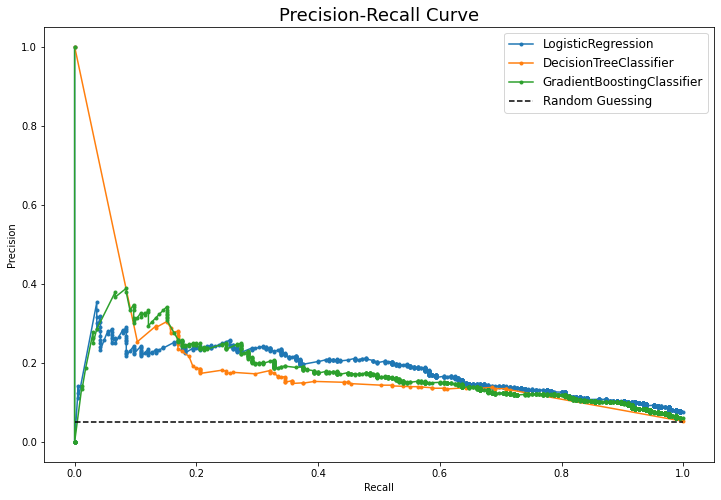

In [ ]:
plt.figure(figsize=(12,8))
plot_pr_curve(lr_gs, gs_dict)
plot_pr_curve(dt_gs, gs_dict)
plot_pr_curve(gb_gs, gs_dict)
plt.plot([0, 1], [0.05, 0.05], linestyle='--', color = 'black', label='Random Guessing')
plt.title('Precision-Recall Curve', fontsize=18)
plt.legend(fontsize=12);

### Results

In [ ]:
feat_imp = pd.DataFrame(gb_gs.best_estimator_.steps[1][1].feature_importances_, index=X_train.columns, columns=['Importance']).sort_values('Importance', ascending=False)
feat_imp.head(10)

,Importance
Longitude,0.177102
Sunrise,0.171190
Species,0.117570
Latitude,0.103238
Sunset,0.072022
WeekPrecipTotal,0.058936
YearWeek,0.058562
Week,0.044281
templag3,0.029897
ResultSpeed,0.026804


In [ ]:
# Refit model on training data
final_model = lr_gs.fit(X, y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   26.2s finished


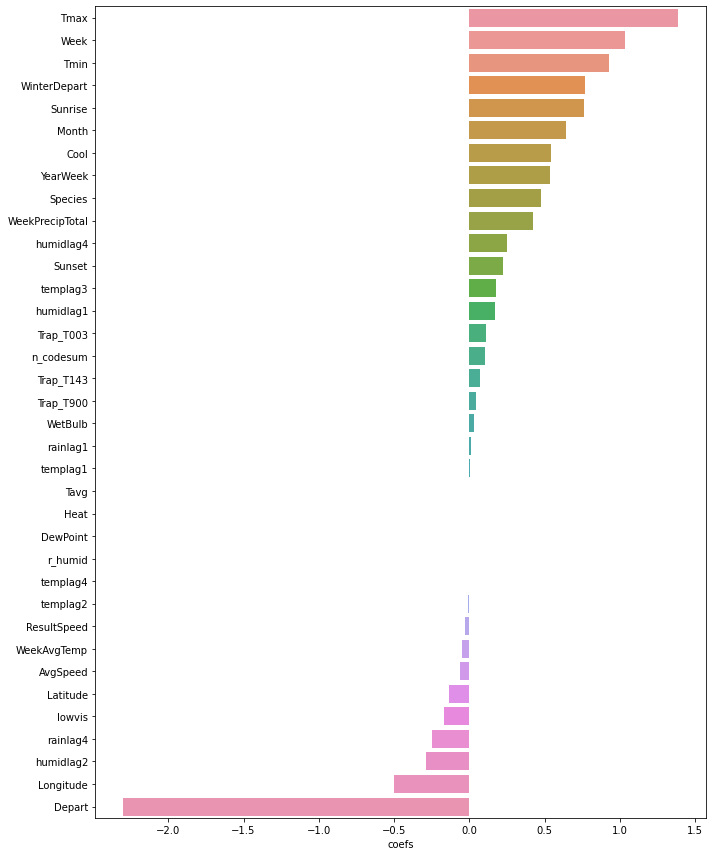

In [ ]:
lr_gs_df = pd.DataFrame(columns=X.columns, data=lr_gs.best_estimator_.steps[1][1].coef_).T
lr_gs_df.columns = ['coefs']
lr_gs_df = lr_gs_df.sort_values(ascending=False, by='coefs')
plt.figure(figsize=(10, 12))
sns.barplot(data=lr_gs_df, y=lr_gs_df.index, x='coefs', orient='h')
plt.tight_layout()
#plt.savefig(fname='./assets/final_model', dpi=300)

In [ ]:
predictions = final_model.predict(final_test)

In [ ]:
df = pd.DataFrame(predictions)
df[0].value_counts()

0    115044
1      1249
Name: 0, dtype: int64

In [ ]:
pred_proba = final_model.predict_proba(final_test)

In [ ]:
pred_proba_t = [i[1] for i in pred_proba]

In [ ]:
# Saving final model for further analysis
filename = './assets/final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))

### Submission

In [ ]:
submission = pd.DataFrame()
submission['Id'] = test_id
submission['WnvPresent'] = pred_proba_t
submission

,Id,WnvPresent
0,1,0.000077
1,2,0.000031
2,3,0.000077
3,4,0.000013
4,5,0.000013
...,...,...
116288,116289,0.000594
116289,116290,0.000594
116290,116291,0.000594
116291,116292,0.000594


#### Manual Tuning

In [ ]:
test['Date'] = pd.to_datetime(test['Date'])
test['Year'] = test['Date'].apply(lambda x: x.year)

In [ ]:
submission['Year'] = test['Year']

In [ ]:
def year_mod(row):
    if row['Year'] == 2012:
        row['WnvPresent'] = row['WnvPresent'] * 2
        if row['WnvPresent'] > 1:
            row['WnvPresent'] = 0.99
    return row

In [ ]:
submission = submission.apply(year_mod, axis=1)

In [ ]:
submission['Id'] = submission['Id'].astype(int)

In [ ]:
submission = submission.drop(columns='Year')

#### Export to CSV

In [ ]:
submission.to_csv('kaggle.csv', index=False)

In [ ]:
# Adaboost -- 0.69791
# LogReg -- 0.79402
# GradientBoost -- 0.67130